## 1. Upload the data nd libraries

### 1.1 Imports necessary libraries

In [1]:
# Python
import pickle

# Third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager

### 1.2 Import the data

In [2]:

data_path_manager = DataPathCleaningManager(data_timeplace)
df = data_path_manager._load_cleaned_df(domain="combined")

In [3]:
# choose relevant columns
df.columns.tolist()

[('listing', 'link'),
 ('listing', 'title'),
 ('listing', 'summary_description'),
 ('listing', 'remote_service'),
 ('pricing', 'price'),
 ('pricing', 'rent'),
 ('pricing', 'total_rent'),
 ('pricing', 'total_rent_sqm'),
 ('pricing', 'deposit'),
 ('pricing', 'deposit_ratio'),
 ('location', 'complete_address'),
 ('location', 'street'),
 ('location', 'city'),
 ('location', 'voivodeship'),
 ('size', 'square_meters'),
 ('size', 'number_of_rooms'),
 ('size', 'floor'),
 ('size', 'attic'),
 ('size', 'building_floors'),
 ('legal_and_availability', 'available_from'),
 ('legal_and_availability', 'completion'),
 ('legal_and_availability', 'ownership'),
 ('legal_and_availability', 'rent_to_students'),
 ('type_and_year', 'building_type'),
 ('type_and_year', 'build_year'),
 ('amenities', 'elevator'),
 ('amenities', 'parking_space'),
 ('equipment', 'no_information'),
 ('equipment', 'stove'),
 ('equipment', 'fridge'),
 ('equipment', 'furniture'),
 ('equipment', 'oven'),
 ('equipment', 'washing_machine')

### 1.3 Select relevant data

In [4]:
df_model = pd.DataFrame()

columns_to_select = [
    ('pricing', 'total_rent'),
    ('location', 'city'),
    ('size', 'square_meters'),
    # ('size', 'number_of_rooms'),
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    ('amenities', 'elevator'),
    ('amenities', 'parking_space'),
    # ('equipment', 'stove'),
    ('equipment', 'oven'),
    ('equipment', 'washing_machine'),
    ('equipment', 'TV'),
    ('equipment', 'dishwasher'),
    ('media_types', 'internet'),
    ('media_types', 'cable_TV'),
    ('heating', 'district'),
    ('security', 'monitoring_or_security'),
    ('security', 'anti_burglary_doors_or_windows'),
    ('security', 'enclosed_area'),
    ('windows', 'aluminum'),
    ('size', 'floor'),
    ('size', 'building_floors'),
    ('additional_information', 'air_conditioning'),
    ('additional_information', 'utility_room'),
]

extracted_columns = df.loc[:, columns_to_select]


extracted_columns.columns = extracted_columns.columns.droplevel(0)

extracted_columns = extracted_columns.rename(columns={
    'district': 'heating_district',
    'aluminum': 'windows_aluminum',
})
df_model[extracted_columns.columns] = extracted_columns

df_model.columns


Index(['total_rent', 'city', 'square_meters', 'building_type', 'build_year',
       'elevator', 'parking_space', 'oven', 'washing_machine', 'TV',
       'dishwasher', 'internet', 'cable_TV', 'heating_district',
       'monitoring_or_security', 'anti_burglary_doors_or_windows',
       'enclosed_area', 'windows_aluminum', 'floor', 'building_floors',
       'air_conditioning', 'utility_room'],
      dtype='object')

## 2. Get dummy data

Transforms categorical variables into numerical form by creating binary indicator variables for each category, resulting in a new DataFrame called 'df_dum'

In [5]:
df_dum = pd.get_dummies(df_model)

In [6]:
df_dum.columns

Index(['total_rent', 'square_meters', 'build_year', 'elevator',
       'parking_space', 'oven', 'washing_machine', 'TV', 'dishwasher',
       'internet', 'cable_TV', 'heating_district', 'monitoring_or_security',
       'anti_burglary_doors_or_windows', 'enclosed_area', 'windows_aluminum',
       'floor', 'building_floors', 'air_conditioning', 'utility_room',
       'city_Bytom', 'city_Chorzów', 'city_Dąbrowa Górnicza', 'city_Jaworzno',
       'city_Katowice', 'city_Mysłowice', 'city_Piekary Śląskie',
       'city_Ruda Śląska', 'city_Siemianowice Śląskie', 'city_Sosnowiec',
       'city_Zawada', 'city_będziński', 'city_częstochowski',
       'city_myszkowski', 'city_tarnogórski', 'city_zawierciański',
       'city_Świętochłowice', 'building_type_apartment_building',
       'building_type_block_of_flats', 'building_type_detached_house',
       'building_type_historic_apartment_building',
       'building_type_terraced_house'],
      dtype='object')

## 3. Train the split
Splits the data into two separate datasets, one for training the model and the other for testing its performance, using the train_test_split function from scikit-learn.

In [7]:
X = df_dum.drop('total_rent', axis =1)
Y = df_dum['total_rent']

# Convert boolean columns to integers (0s and 1s)
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Replace NaNs and infinities in X
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Replace NaNs and infinities in Y
Y = Y.replace([np.inf, -np.inf], np.nan)
Y = Y.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values, test_size=0.2, random_state=42)

In [8]:
my_xnames = pd.Index(['total_rent'] + X.columns.tolist())

## 4. Multiple linear regression
Utilizes the OLS method from the statsmodels library to estimate the relationship between multiple independent variables and a dependent variable through linear regression.

In [9]:
# # Convert boolean columns to integers (0s and 1s)
# bool_cols = X.select_dtypes(include=['bool']).columns
# X[bool_cols] = X[bool_cols].astype(int)

# # Replace pandas.NA and other non-numeric types with np.nan
# X = X.applymap(lambda x: np.nan if pd.isna(x) else x)
# Y = Y.apply(lambda x: np.nan if pd.isna(x) else x)

# # Convert NaN values to 0.0 and infinite values to large finite numbers
# X = np.nan_to_num(X.values, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
# Y = np.nan_to_num(Y.values, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

# Adding constant to X for the intercept term

X = np.asarray(X)
Y = np.asarray(Y)

X = np.nan_to_num(X)
Y = np.nan_to_num(Y)

X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float)

X_sm = sm.add_constant(X)

# Constructing the model
model = sm.OLS(Y, X_sm)
model.data.xnames = my_xnames.tolist()

In [10]:
results = model.fit().summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     35.82
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          1.49e-167
Time:                        20:09:04   Log-Likelihood:                -9142.6
No. Observations:                1106   AIC:                         1.837e+04
Df Residuals:                    1065   BIC:                         1.857e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
total_rent                                  338.9902    144.412      2.347      0.019      55.626     622.355
square_meters                                26.0252      1.197     21.748      0.000      23.677      28.373
build_year                                   -0.0252      0.034     -0.741      0.459      -0.092       0.042
elevator                                    303.8943     87.573      3.470      0.001     132.059     475.730
parking_space                               185.4476     77.128      2.404      0.016      34.107     336.788
oven                                         35.1139     97.416      0.360      0.719    -156.035     226.263
washing_machine                              13.7955    101.536      0.136      0.892    -185.438     213.029
TV                                         -158.8472     85.397     -1.860      0.063    -326.413       8.718
dishwasher                                  187.7250     87.535      2.145      0.032      15.965     359.485
internet                                    -56.9997     90.165     -0.632      0.527    -233.922     119.922
cable_TV                                    100.7686     93.352      1.079      0.281     -82.406     283.943
heating_district                            117.1288     74.395      1.574      0.116     -28.848     263.105
monitoring_or_security                       36.5430     92.555      0.395      0.693    -145.068     218.154
anti_burglary_doors_or_windows               30.0356     86.269      0.348      0.728    -139.242     199.313
enclosed_area                               -37.2877     98.643     -0.378      0.706    -230.844     156.269
windows_aluminum                           4648.3028    495.857      9.374      0.000    3675.336    5621.270
floor                                         9.4549     15.515      0.609      0.542     -20.989      39.899
building_floors                              -7.8488     11.118     -0.706      0.480     -29.664      13.966
air_conditioning                            779.4911    116.125      6.713      0.000     551.631    1007.351
utility_room                               -143.2375     96.283     -1.488      0.137    -332.163      45.688
city_Bytom                                  -53.6121    135.238     -0.396      0.692    -318.974     211.750
city_Chorzów                                236.0396    158.035      1.494      0.136     -74.055     546.134
city_Dąbrowa Górnicza                       271.7495    155.623      1.746      0.081     -33.613     577.112
city_Jaworzno                               181.7546    188.644      0.963      0.336    -188.402     551.912
city_Katowice                               544.6353    118.723      4.587      0.000     311.678     777.593
cit

C:\Users\karol\AppData\Local\Temp\ipykernel_60936\3920633229.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_model.corr()


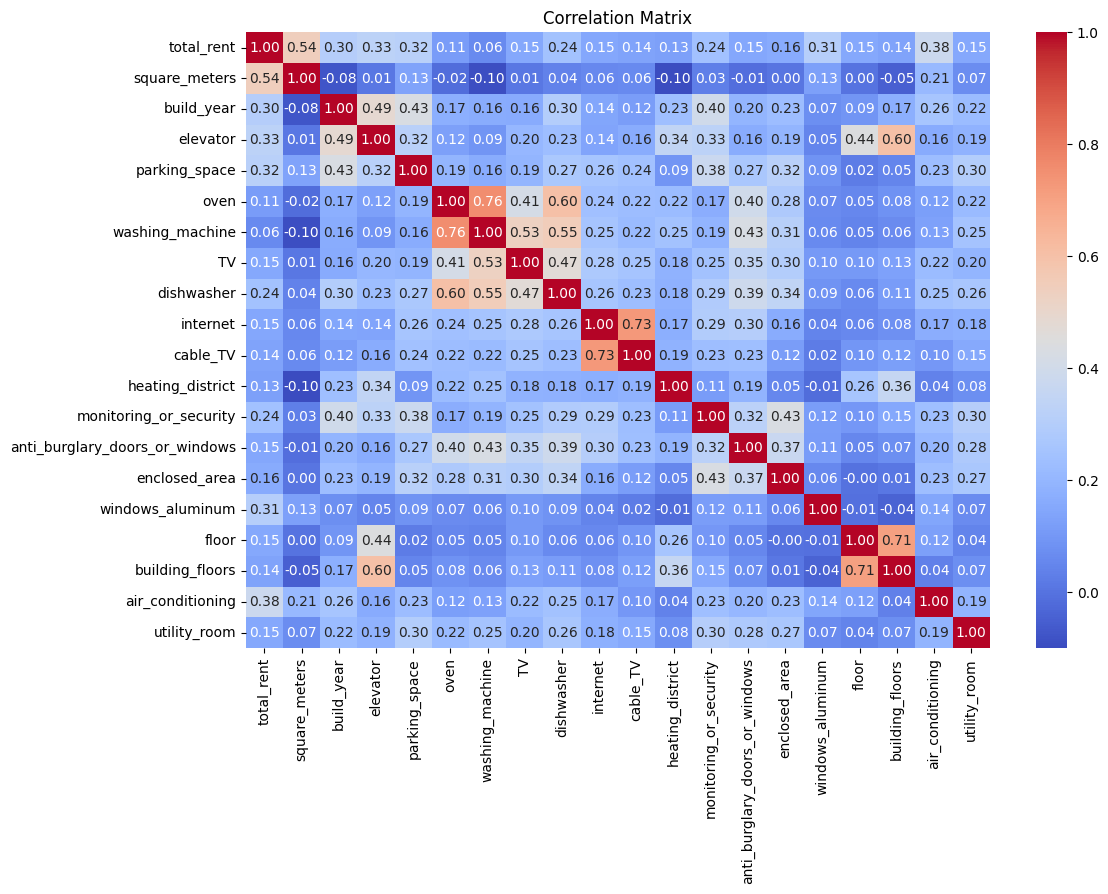

In [11]:
corr_matrix = df_model.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [12]:
def get_t_results(results, t_cap):
    table_index = 1

    table_data = results.tables[table_index].data

    filtered_data = [row for row in table_data if float(row[-2].replace("[", "")) >= t_cap]

    sorted_data = sorted(filtered_data, key=lambda x: float(x[-2].replace("[", "")), reverse=True)

    filtered_table = SimpleTable(sorted_data, title=results.tables[table_index].title)

    print(f"passed_t_variables: {len(filtered_data)}")
    print(f"variables: {len(table_data)}")
    print(f"percentage: {round((len(filtered_data) / len(table_data)) * 100, 2)}")
    return filtered_table

get_t_results(results, 0.05)

passed_t_variables: 9
variables: 43
percentage: 20.93


windows_aluminum,4648.3028,495.857,9.374,0.000,3675.336,5621.270
air_conditioning,779.4911,116.125,6.713,0.000,551.631,1007.351
building_type_apartment_building,651.2366,133.170,4.890,0.000,389.932,912.541
city_Katowice,544.6353,118.723,4.587,0.000,311.678,777.593
elevator,303.8943,87.573,3.470,0.001,132.059,475.730
total_rent,338.9902,144.412,2.347,0.019,55.626,622.355
parking_space,185.4476,77.128,2.404,0.016,34.107,336.788
square_meters,26.0252,1.197,21.748,0.000,23.677,28.373
dishwasher,187.7250,87.535,2.145,0.032,15.965,359.485


In [24]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

np.mean(cross_val_score(lm,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv=10))

-565.131541995817

## 5. Lasso regression
Performs Lasso regression with different alpha values and calculates the mean absolute error for each alpha value.

In [33]:
lm_l = Lasso(alpha=.99)
lm_l.fit(X_train,Y_train)
avg_score = np.mean(cross_val_score(lm_l,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv= 10))
avg_score

-561.2293596380372

c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.238e+07, tolerance: 1.652e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e+07, tolerance: 1.668e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

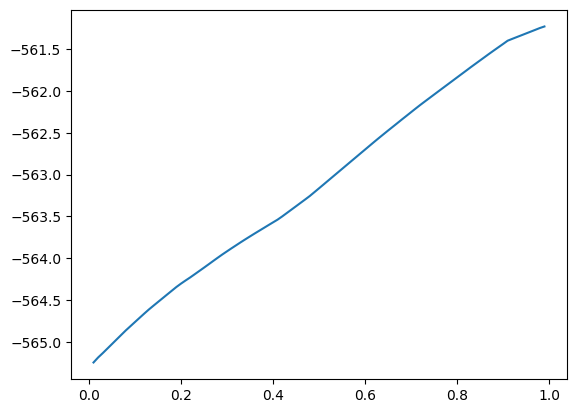

Best alpha: 0.99


In [30]:
alpha = []
error = []

# Loop to populate alpha and error lists
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml, X_train, Y_train, scoring='neg_mean_absolute_error', cv=10)))

# Plotting
plt.plot(alpha, error)
plt.show()

# Finding the best alpha
best_alpha_index = np.argmax(error)  # Get the index of the best error
best_alpha = alpha[best_alpha_index]  # Use index to find the corresponding alpha
print(f"Best alpha: {best_alpha}")


## 6. Random Forest
Creates a random forest regressor (rf) and calculates the mean absolute error using cross-validation.

In [36]:
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,Y_train,scoring = 'neg_mean_absolute_error', cv= 15))

-480.67398304157047

## 7. Tune Models GridsearchCV
Performs hyperparameter tuning for the random forest model using GridSearchCV, trying different combinations of n_estimators, criterion, and max_features.

In [37]:
parameters = {'n_estimators':range(10,300,10), 'criterion':('friedman_mse','absolute_error', 'poisson', 'squared_error'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,Y_train)

gs.best_score_
gs.best_estimator_

c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomForestRegressor(criterion='poisson', max_features='auto',
                      n_estimators=210)

In [38]:
# test ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

print(f"tpred_lm: {mean_absolute_error(Y_test,tpred_lm)}")
print(f"tpred_lml: {mean_absolute_error(Y_test,tpred_lml)}")
print(f"tpred_rf: {mean_absolute_error(Y_test,tpred_rf)}")

print(f"tpred_lm + tpred_rf: {mean_absolute_error(Y_test,(tpred_lm+tpred_rf)/2)}")
print(f"tpred_lm + tpred_lml: {mean_absolute_error(Y_test,(tpred_lm+tpred_lml)/2)}")
print(f"tpred_rf + tpred_lml: {mean_absolute_error(Y_test,(tpred_lml+tpred_rf)/2)}")

tpred_lm: 575.9796859807857
tpred_lml: 568.6905543163115
tpred_rf: 450.52960817960815
tpred_lm + tpred_rf: 487.7432714818993
tpred_lm + tpred_lml: 572.2801925764787
tpred_rf + tpred_lml: 484.9294782756096


In [39]:
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

In [40]:
file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [42]:
model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))

c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([1034.18095238])

In [43]:
list(X_test.iloc[0,:])

[70.0,
 2019.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 2.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0]